In [ ]:
# Instalação de Bibliotecas
pip install pandas numpy matplotlib scikit-learn tensorflow keras seaborn

In [3]:
# Importação de Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier

import shap

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, SpatialDropout1D, SimpleRNN, Embedding
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Carregar os dados
df = pd.read_csv("C:/Users/ana_v/OneDrive/Documentos/Repositórios/GSE25066.csv", low_memory=False)

# Obtém os valores únicos na coluna 'Type'
unique_types = df['type'].unique()

# Cria um dicionário mapeando cada tipo único para um número
type_to_numeric = {type_name: index for index, type_name in enumerate(unique_types)}

# Aplica a substituição usando o método map
df['type'] = df['type'].map(type_to_numeric)

# Armazena a coluna 'type' para adicioná-la de volta posteriormente
type_column = df['type']

# Prepara o DataFrame para normalização (remover colunas desnecessárias)
df_num = df.drop(columns=["sample", "type"])

# Normalizar os dados
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df_num)

# Aplicação do PCA
pca = PCA(n_components=0.8)  
pca.fit(dados_normalizados)
dados_pca = pca.transform(dados_normalizados)

In [5]:
# Exibe o mapeamento original de 'Type' para números
print("Mapeamento de tipos originais para rótulos numéricos:")
for type_name, numeric_value in type_to_numeric.items():
    print(f"'{type_name}' -> {numeric_value}") 

Mapeamento de tipos originais para rótulos numéricos:
'LumA' -> 0
'Normal' -> 1
'Basal' -> 2
'LumB' -> 3
'Her2' -> 4


In [6]:
# Fixar a seed para garantir a reprodutibilidade
seed = 1

# Divisão de treino e teste com random_state
X_train, X_test, y_train, y_test = train_test_split(dados_pca, df['type'], test_size=0.2, random_state=seed)

In [7]:
# Regressão Logística
lr_model = LogisticRegression(max_iter=6500) 
lr_model.fit(X_train, y_train) 
lr_predictions_train = lr_model.predict(X_train)  
lr_predictions_test = lr_model.predict(X_test) 

# Avaliação Regressão Logística
lr_accuracy_train = accuracy_score(y_train, lr_predictions_train) 
lr_accuracy_test = accuracy_score(y_test, lr_predictions_test)  
lr_report = classification_report(y_test, lr_predictions_test, zero_division=1) 

# Criar um objeto de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Substituir a divisão de treino e teste pelo código de validação cruzada
scores = cross_val_score(lr_model, dados_pca, df['type'], cv=cv, scoring='accuracy')

# Imprimir os resultados
print(f'Regressão Logística - Acurácia (Teste): {lr_accuracy_test}')
print(f'Acurácia média na validação cruzada: {scores.mean()}')
print(f'Classification Report:\n{lr_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, lr_predictions_test))


Regressão Logística - Acurácia (Teste): 0.803921568627451
Acurácia média na validação cruzada: 0.7894901960784313
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        34
           1       0.50      0.62      0.56         8
           2       1.00      0.90      0.95        40
           3       0.62      0.77      0.69        13
           4       0.57      0.57      0.57         7

    accuracy                           0.80       102
   macro avg       0.70      0.73      0.71       102
weighted avg       0.82      0.80      0.81       102

Matriz de Confusão:
 [[27  2  0  4  1]
 [ 1  5  0  0  2]
 [ 1  3 36  0  0]
 [ 3  0  0 10  0]
 [ 1  0  0  2  4]]


In [8]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)  
rf_predictions_train = rf_model.predict(X_train)  
rf_predictions_test = rf_model.predict(X_test) 

# Avaliação Random Forest
rf_accuracy_train = accuracy_score(y_train, rf_predictions_train) 
rf_accuracy_test = accuracy_score(y_test, rf_predictions_test) 
rf_report = classification_report(y_test, rf_predictions_test, 
                                  zero_division=1) 

# Criar um objeto de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Substituir a divisão de treino e teste pelo código de validação cruzada
scores_rf = cross_val_score(rf_model, dados_pca, df['type'], cv=cv, scoring='accuracy')

# Imprimir os resultados
print(f'Random Forest - Acurácia (Teste): {rf_accuracy_test}')
print(f'Acurácia média na validação cruzada: {scores_rf.mean()}')
print(f'Classification Report:\n{rf_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, rf_predictions_test))


Random Forest - Acurácia (Teste): 0.6764705882352942
Acurácia média na validação cruzada: 0.6397647058823529
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68        34
           1       1.00      0.12      0.22         8
           2       0.72      0.95      0.82        40
           3       1.00      0.23      0.38        13
           4       1.00      0.00      0.00         7

    accuracy                           0.68       102
   macro avg       0.86      0.42      0.42       102
weighted avg       0.76      0.68      0.61       102

Matriz de Confusão:
 [[27  0  7  0  0]
 [ 5  1  2  0  0]
 [ 2  0 38  0  0]
 [ 7  0  3  3  0]
 [ 4  0  3  0  0]]


In [9]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)  
svm_predictions_train = svm_model.predict(X_train)  
svm_predictions_test = svm_model.predict(X_test) 

# Avaliação SVM
svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)  
svm_accuracy_test = accuracy_score(y_test, svm_predictions_test)  
svm_report = classification_report(y_test, svm_predictions_test, zero_division=1)  

# Criar um objeto de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Substituir a divisão de treino e teste pelo código de validação cruzada
scores_svm = cross_val_score(svm_model, dados_pca, df['type'], cv=cv, 
                         scoring='accuracy')

# Imprimir os resultados
print(f'SVM - Acurácia (Teste): {svm_accuracy_test}')
print(f'Acurácia média na validação cruzada: {scores_svm.mean()}')
print(f'Classification Report:\n{lr_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, svm_predictions_test))


SVM - Acurácia (Teste): 0.7647058823529411
Acurácia média na validação cruzada: 0.7658431372549019
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        34
           1       0.50      0.62      0.56         8
           2       1.00      0.90      0.95        40
           3       0.62      0.77      0.69        13
           4       0.57      0.57      0.57         7

    accuracy                           0.80       102
   macro avg       0.70      0.73      0.71       102
weighted avg       0.82      0.80      0.81       102

Matriz de Confusão:
 [[32  0  0  2  0]
 [ 4  3  0  0  1]
 [ 2  0 37  0  1]
 [ 9  0  0  4  0]
 [ 2  0  1  2  2]]


In [10]:
# Criação e treinamento do MLP com 4 camadas ocultas
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 75, 50, 25), max_iter=500, random_state=seed)
mlp_model.fit(X_train, y_train)

# Predições no conjunto de treino e teste
mlp_predictions_train = mlp_model.predict(X_train)
mlp_predictions_test = mlp_model.predict(X_test)

# Avaliação MLP
mlp_accuracy_train = accuracy_score(y_train, mlp_predictions_train)
mlp_accuracy_test = accuracy_score(y_test, mlp_predictions_test)
mlp_report = classification_report(y_test, mlp_predictions_test, zero_division=1)

# Criar um objeto de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Substituir a divisão de treino e teste pelo código de validação cruzada
mlp_scores = cross_val_score(mlp_model, dados_pca, df['type'], cv=cv, scoring='accuracy')

# Exibindo resultados do MLP
print(f'MLP - Acurácia (Teste): {mlp_accuracy_test}')
print(f'Acurácia média na validação cruzada (MLP): {mlp_scores.mean()}')
print(f'Classification Report MLP:\n{mlp_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, mlp_predictions_test))


MLP - Acurácia (Teste): 0.6862745098039216
Acurácia média na validação cruzada (MLP): 0.6988235294117647
Classification Report MLP:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        34
           1       0.60      0.38      0.46         8
           2       0.84      0.90      0.87        40
           3       0.33      0.31      0.32        13
           4       0.60      0.43      0.50         7

    accuracy                           0.69       102
   macro avg       0.60      0.54      0.57       102
weighted avg       0.68      0.69      0.68       102

Matriz de Confusão:
 [[24  1  2  7  0]
 [ 2  3  1  1  1]
 [ 3  1 36  0  0]
 [ 6  0  2  4  1]
 [ 2  0  2  0  3]]


In [11]:
np.random.seed(seed)
tf.random.set_seed(seed)

unique_types = df['type'].unique()
num_classes = len(unique_types)
target_names = [str(cls) for cls in unique_types]

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Função para criar o modelo CNN
def create_cnn_model():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])
    return model

# Validação cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cross_val_scores = []

for train_index, val_index in kfold.split(X_train):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    model = create_cnn_model()
    history = model.fit(X_fold_train, y_fold_train, epochs=25, batch_size=32, verbose=0, validation_data=(X_fold_val, y_fold_val))

    val_accuracy = history.history['val_accuracy'][-1]
    cross_val_scores.append(val_accuracy)

cross_val_mean = np.mean(cross_val_scores)
cross_val_std = np.std(cross_val_scores)

# Treinamento final da CNN
model = create_cnn_model()
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Avaliação da CNN no conjunto de teste
cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test)

# Exibindo resultados da CNN
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Predições da CNN no conjunto de teste
cnn_predictions = model.predict(X_test)
cnn_predictions_classes = np.argmax(cnn_predictions, axis=1)

# Classification report da CNN
cnn_report = classification_report(y_test, cnn_predictions_classes, target_names=target_names, zero_division=1, digits=2)

c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2889 - loss: 3.9968 - val_accuracy: 0.4020 - val_loss: 1.4240
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3571 - loss: 1.4858 - val_accuracy: 0.4314 - val_loss: 1.4037
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4722 - loss: 1.3854 - val_accuracy: 0.5000 - val_loss: 1.3745
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5516 - loss: 1.2437 - val_accuracy: 0.5196 - val_loss: 1.2546
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5492 - loss: 1.1644 - val_accuracy: 0.5392 - val_loss: 1.2435
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6071 - loss: 1.0172 - val_accuracy: 0.5490 - val_loss: 1.1161
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6064 - loss: 1.0054 - val_accuracy: 0.5686 - val_loss: 1.1202
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6503 - loss: 0.9037 - val_accuracy: 0.5588 - val_l

In [12]:
# Resultados
print(f'Acurácia média na validação cruzada (CNN): {cross_val_mean:.4f} ± {cross_val_std:.4f}')
print(f'Acurácia (Teste): {cnn_accuracy:.4f}')
print(f'Classification Report CNN:\n{cnn_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, cnn_predictions_classes))

Acurácia média na validação cruzada (CNN): 0.6353 ± 0.0663
Acurácia (Teste): 0.6078
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        34
           1       0.60      0.38      0.46         8
           2       0.66      0.82      0.73        40
           3       0.31      0.31      0.31        13
           4       0.33      0.14      0.20         7

    accuracy                           0.61       102
   macro avg       0.52      0.45      0.47       102
weighted avg       0.59      0.61      0.59       102

Matriz de Confusão:
 [[21  2  6  5  0]
 [ 0  3  3  1  1]
 [ 5  0 33  2  0]
 [ 4  0  4  4  1]
 [ 1  0  4  1  1]]


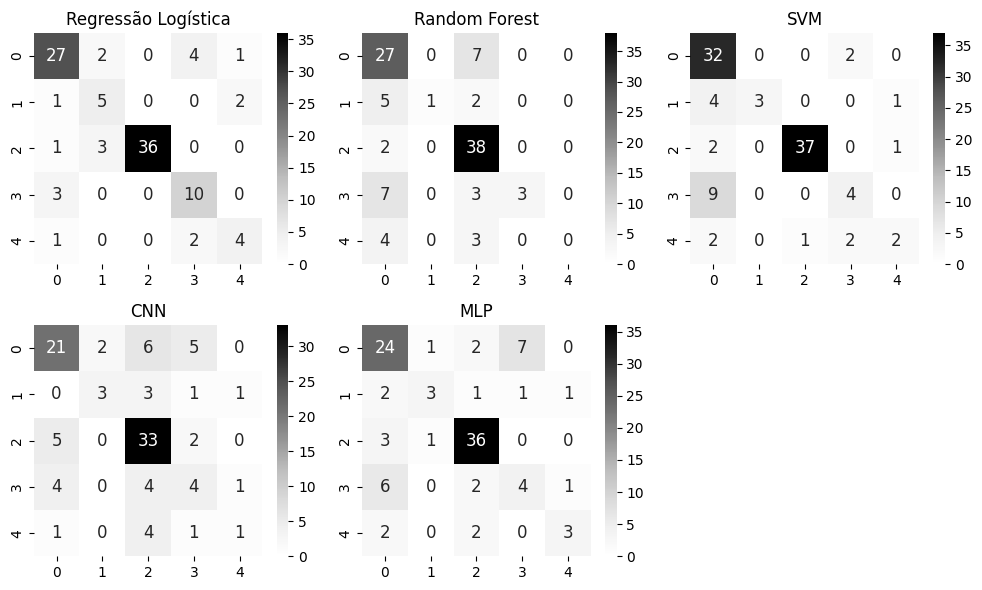

In [13]:
# Definir unique_types e target_names
unique_types = df['type'].unique()
target_names = [str(cls) for cls in unique_types]

# Matrizes de confusão
conf_matrix_lr = confusion_matrix(y_test, lr_predictions_test)
conf_matrix_rf = confusion_matrix(y_test, rf_predictions_test)
conf_matrix_svm = confusion_matrix(y_test, svm_predictions_test)
conf_matrix_cnn = confusion_matrix(y_test, cnn_predictions_classes)
conf_matrix_mlp = confusion_matrix(y_test, mlp_predictions_test)

# Função para plotar a matriz de confusão em um subplot específico
def plot_confusion_matrix_subplot(ax, conf_matrix, title):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', 
                xticklabels=target_names, yticklabels=target_names, 
                annot_kws={"size": 12}, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Criar uma figura com subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Adicionar as matrizes de confusão a cada subplot
plot_confusion_matrix_subplot(axes[0, 0], conf_matrix_lr, 'Regressão Logística')
plot_confusion_matrix_subplot(axes[0, 1], conf_matrix_rf, 'Random Forest')
plot_confusion_matrix_subplot(axes[0, 2], conf_matrix_svm, 'SVM')
plot_confusion_matrix_subplot(axes[1, 1], conf_matrix_mlp, 'MLP')
plot_confusion_matrix_subplot(axes[1, 0], conf_matrix_cnn, 'CNN')

# Remover o último subplot vazio (opcional)
fig.delaxes(axes[1, 2])

# Ajustar o layout
plt.tight_layout()

# Salvar a figura completa com as 5 matrizes de confusão
plt.savefig('all_confusion_matrices_geo.png')

# Mostrar a figura
plt.show()

Using 406 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(406, 250)


100%|██████████| 102/102 [1:56:18<00:00, 68.41s/it]


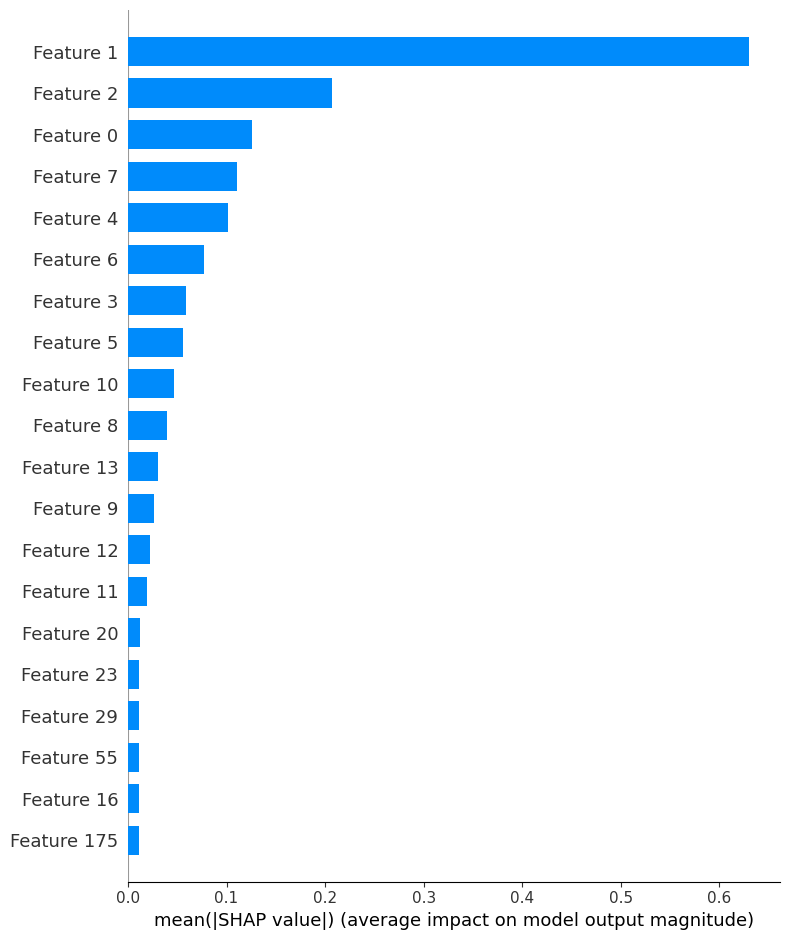

In [14]:
# Ajustar a dimensionalidade dos dados
X_train = np.squeeze(X_train)  
X_test = np.squeeze(X_test)

print(X_train.shape) 

# Criação do interpretador SHAP para o SVM
explainer = shap.KernelExplainer(svm_model.predict, X_train)

# Calculando os valores SHAP
shap_values = explainer.shap_values(X_test)

# Plotando a importância das variáveis
shap.summary_plot(shap_values, X_train, plot_type="bar")

Using 406 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 102/102 [11:23<00:00,  6.70s/it]


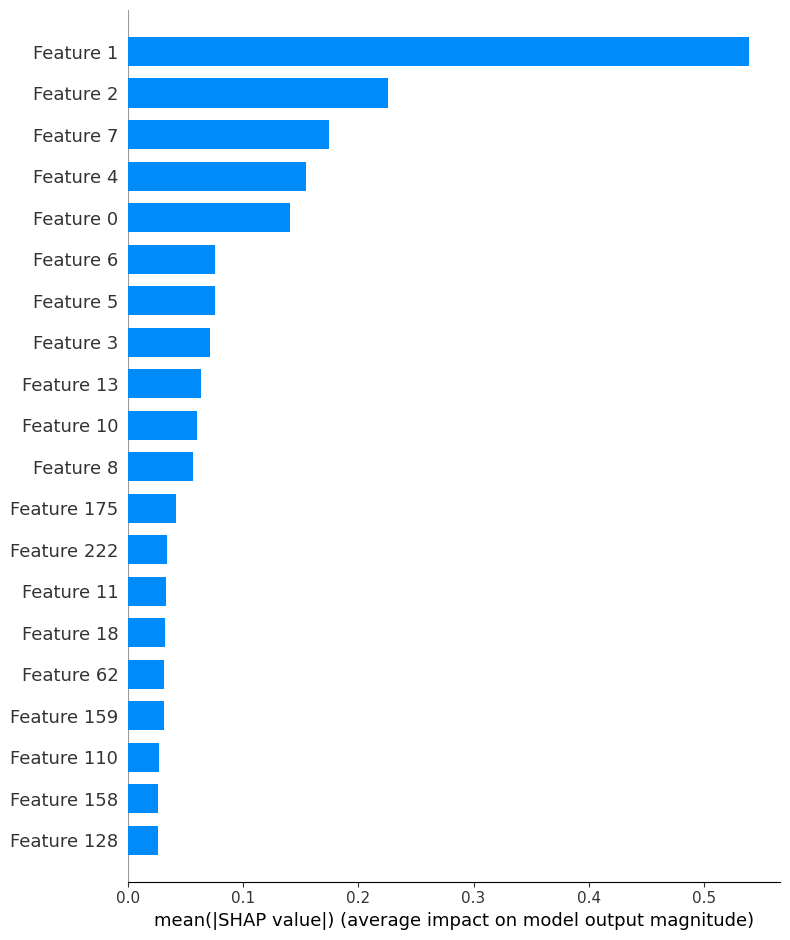

In [15]:
# Criando o interpretador SHAP para Regressão Logística
explainer_lr = shap.KernelExplainer(lr_model.predict, X_train)

# Calculando os valores SHAP
shap_values_lr = explainer_lr.shap_values(X_test)

# Plotando a importância das variáveis
shap.summary_plot(shap_values_lr, X_train, plot_type="bar")

Using 406 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 102/102 [26:29<00:00, 15.58s/it]


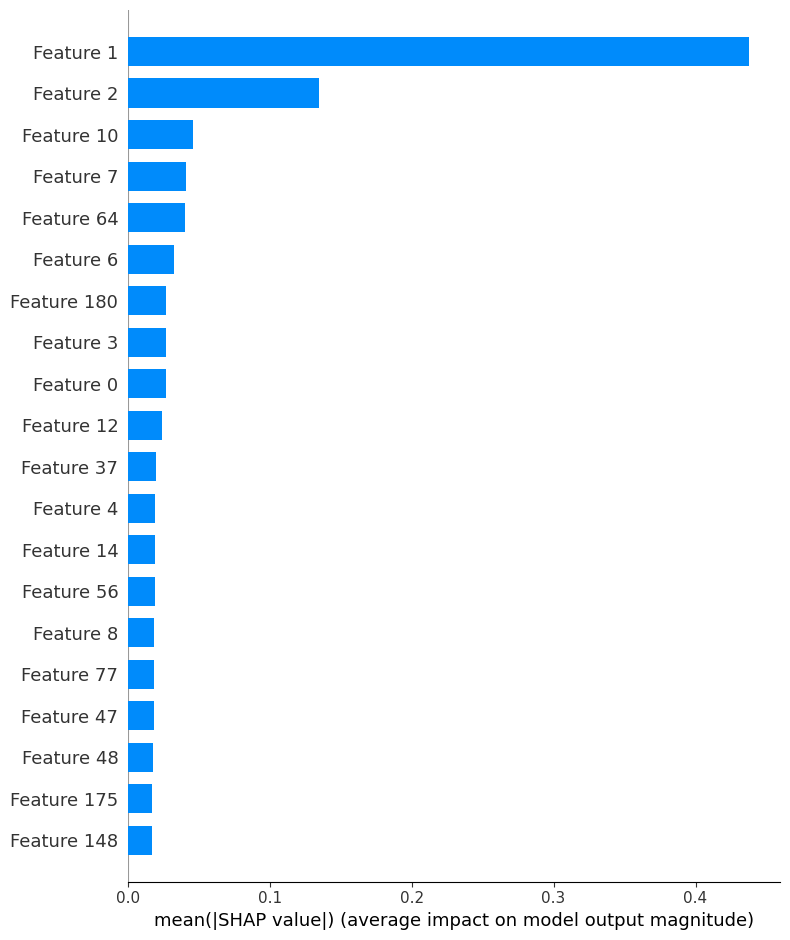

In [16]:
# Criando o interpretador SHAP para Random Forest
explainer_rf = shap.KernelExplainer(rf_model.predict, X_train)

# Calculando os valores SHAP
shap_values_rf = explainer_rf.shap_values(X_test)

# Plotando a importância das variáveis
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

Using 406 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 102/102 [14:15<00:00,  8.39s/it]


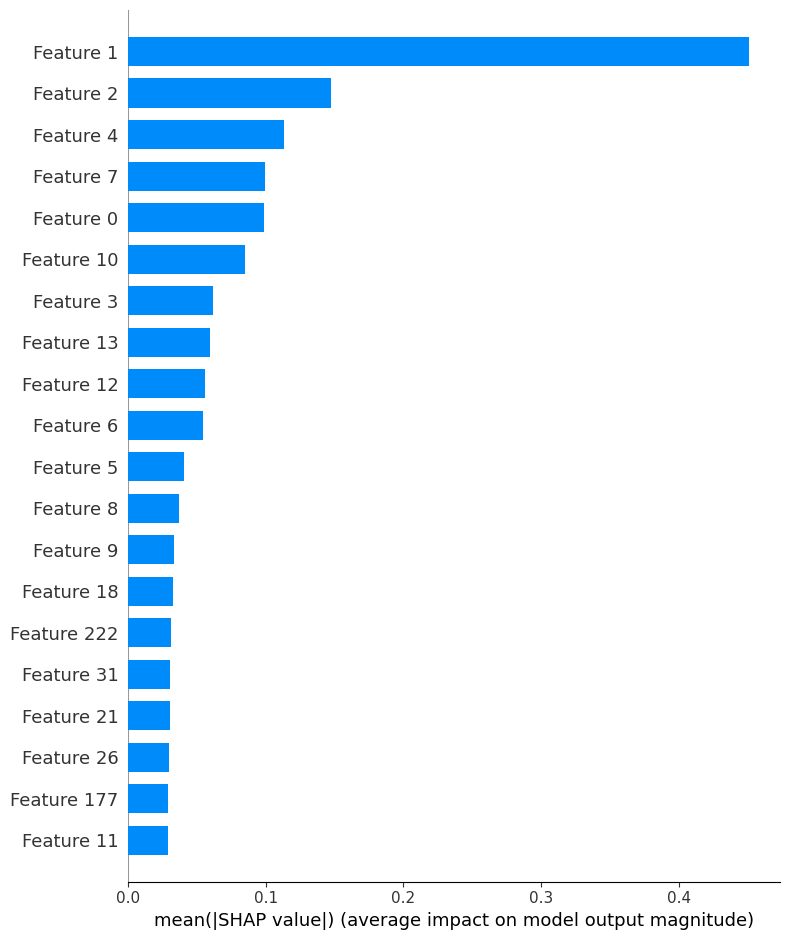

In [17]:
# Criando o interpretador SHAP para Random Forest
explainer_mlp = shap.KernelExplainer(mlp_model.predict, X_train)

# Calculando os valores SHAP
shap_values_mlp = explainer_mlp.shap_values(X_test)

# Plotando a importância das variáveis
shap.summary_plot(shap_values_mlp, X_train, plot_type="bar")

In [18]:
# SHAP para CNN
explainer_cnn = shap.DeepExplainer(model, X_train[:100])
shap_values_cnn = explainer_cnn.shap_values(X_test[:100])

# Plotando a importância das variáveis
shap.summary_plot(shap_values_cnn, X_test[:100], plot_type="bar")

c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


ValueError: operands could not be broadcast together with shapes (100,250,1) (100,250) 